# Dynamic Time Warping for Speech Recognition

In [ ]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fftpack import dct
import random
import glob

## Speech feature extraction

In [142]:
path_1 = '/home/jean/Downloads/Data/Data/SIG/SIG_Rep_1_Number_0.wav'
path_2 = '/home/jean/Downloads/Data/Data/SIG/SIG_Rep_2_Number_0.wav'

sample_rate, signal = wavfile.read(path_1)

In [143]:
signal.shape[0]

5098

In [144]:
window_size = 256
window_shift = 128
p = 10

In [145]:
signal_length = signal.shape[0]
num_frames = int(np.ceil(float(np.abs(signal_length - window_size)) / window_shift)) 

In [146]:
num_frames

38

In [147]:
def cepstral (filename, window_size = 256,window_shift = 128,p = 10,nfilt = 40,NFFT = 256, num_ceps=10):
    sample_rate, signal = wavfile.read(filename)
    signal_length = signal.shape[0]

    # Framing
    num_frames = int(np.ceil(float(np.abs(signal_length - window_size)) / window_shift))
    
    # Pad to have equal number of samples without truncating
    pad_signal_length = num_frames * window_shift + window_size
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    
    indices = np.tile(np.arange(0, window_size), (num_frames, 1)) + np.tile(np.arange(0, num_frames * window_shift, window_shift), (window_size, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Reduce spatial leakage and sounterect infinite hypothesis by FFT
    frames *= np.hamming(window_size)
    
    # Fourier transform and power spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    # Filter banks
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    # Cepstral Coefficients
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] 
    
    # Mean normalization to improve signal to noise
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

    return(mfcc)

In [148]:
cepstral(path_1).shape

(38, 10)

## Time alignement by dynamic programming

In [149]:
def align(X,Y,gamma = 1):
    
    # Initiate similarity matrix
    sim = np.zeros((X.shape[0],Y.shape[0]))
    
    # Initiate global distance matrix
    glob = np.zeros((X.shape[0],Y.shape[0]))
    
    # Initiate backpointer
    backpointer = np.zeros((X.shape[0],Y.shape[0],2))
    
    # Get local distance
    for i in range (X.shape[0]):
        for j in range (Y.shape[0]):
            q = X[i] - Y[j]
            sim[i,j] = np.sqrt((q**2).sum())
    
    # Get global distance
    for i in range (X.shape[0]):
        for j in range (Y.shape[0]):
            
            # Starting point
            if (i==0) and (j==0):
                glob[i][j] = sim[i][j]  
                backpointer[i][j] = [None,None]
            
            # 1rst row and 1rst column
            elif (i==0):
                glob[i][j] = glob[i][j-1] + sim[i][j]
                backpointer[i][j] = [i,j-1]
                
            elif (j==0):
                glob[i][j] = glob[i-1][j] + sim[i][j]
                backpointer[i][j] = [i-1,j]
            
            # General case coming from 3 directions
            else:
                lowest_glob = glob[i-1][j]
                backpointer[i][j] = [i-1,j]
                
                if glob[i][j-1] < lowest_glob:
                    lowest_glob = glob[i][j-1]
                    backpointer[i][j] = [i,j-1]
                
                if gamma * glob[i-1][j-1] < lowest_glob:
                    lowest_glob = gamma * glob[i-1][j-1]
                    backpointer[i][j] = [i-1,j-1]
                    
                glob[i][j] = lowest_glob + sim[i][j]
                
    distance = glob[X.shape[0]-1][Y.shape[0]-1]
    
    # Recover the path 
    
    path = []
    i,j = X.shape[0]-1, Y.shape[0]-1
    path.append((i, j))
        
    while (i!=0 or j!=0):
        path.append((int(backpointer[i][j][0]), int(backpointer[i][j][1])))
        i,j =  int(backpointer[i][j][0]), int(backpointer[i][j][1])
                        
    return(distance, path)
    

In [150]:
X = cepstral(path_1)
Y = cepstral(path_2)

In [151]:
align(X,Y)

(121.70942451999342,
 [(37, 35),
  (36, 34),
  (36, 33),
  (35, 32),
  (34, 31),
  (33, 30),
  (32, 30),
  (31, 29),
  (31, 28),
  (30, 27),
  (30, 26),
  (29, 25),
  (28, 24),
  (27, 23),
  (27, 22),
  (26, 21),
  (26, 20),
  (25, 19),
  (24, 18),
  (23, 17),
  (22, 16),
  (21, 15),
  (20, 15),
  (19, 15),
  (18, 14),
  (17, 13),
  (16, 12),
  (16, 11),
  (15, 10),
  (15, 9),
  (14, 8),
  (13, 8),
  (12, 8),
  (11, 8),
  (10, 7),
  (9, 6),
  (8, 5),
  (8, 4),
  (7, 3),
  (6, 2),
  (5, 1),
  (4, 1),
  (3, 0),
  (2, 0),
  (1, 0),
  (0, 0)])

## Application to speech data

Let's take a look at the performances of the realignement to see if it is coherent.

In [152]:
# Realign itself should retrun 0 and full diag

align(X,X)

(0.0,
 [(37, 37),
  (36, 36),
  (35, 35),
  (34, 34),
  (33, 33),
  (32, 32),
  (31, 31),
  (30, 30),
  (29, 29),
  (28, 28),
  (27, 27),
  (26, 26),
  (25, 25),
  (24, 24),
  (23, 23),
  (22, 22),
  (21, 21),
  (20, 20),
  (19, 19),
  (18, 18),
  (17, 17),
  (16, 16),
  (15, 15),
  (14, 14),
  (13, 13),
  (12, 12),
  (11, 11),
  (10, 10),
  (9, 9),
  (8, 8),
  (7, 7),
  (6, 6),
  (5, 5),
  (4, 4),
  (3, 3),
  (2, 2),
  (1, 1),
  (0, 0)])

Let's take rep 1 of zeros and relign it to each other rep in SIG to see if we get coherent results for the distance, i.e. the distance should be lower for the other rep corresponding to the same number than the rep of other number. I chose to do it by averaging over all the rep of each number.

In [153]:
import glob
files = glob.glob('/home/jean/Downloads/Data/Data/SIG/*')

<BarContainer object of 10 artists>

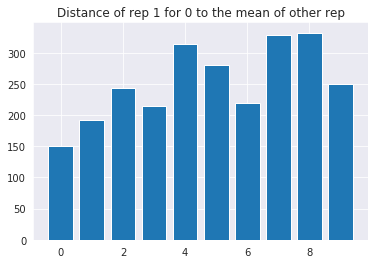

In [154]:
bin_num = np.zeros(10)
for i in files:
    j = int(i[-5])
    Y_diff = cepstral(i)
    bin_num[j] += align(X,Y_diff)[0]
    
bin_num[1:] /= 12
bin_num[0] /= 11

plt.title('Distance of rep 1 for 0 to the mean of other rep')
plt.bar(np.arange(10),bin_num)

As expected the distances for zero ton rep of zero are the closest we get by averaging over 12 rep so it seems to work.

<BarContainer object of 10 artists>

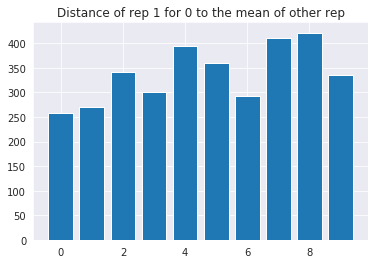

In [155]:
# Let's see the influence of gamma 

gamma = 1.2

bin_num = np.zeros(10)
for i in files:
    j = int(i[-5])
    Y_diff = cepstral(i)
    bin_num[j] += align(X,Y_diff,gamma)[0]
    
bin_num[1:] /= 12
bin_num[0] /= 11

plt.title('Distance of rep 1 for 0 to the mean of other rep')
plt.bar(np.arange(10),bin_num)

We can see with gamma higher than one, an averaging effect because of distorsion we are able to get the repetition closer than before.

<BarContainer object of 10 artists>

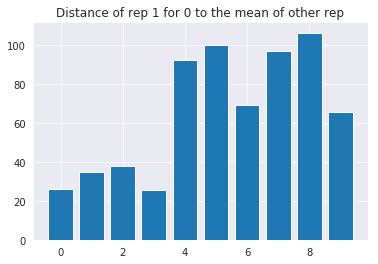

In [156]:
# Let's see the influence of gamma 

gamma = 0.8

bin_num = np.zeros(10)
for i in files:
    j = int(i[-5])
    Y_diff = cepstral(i)
    bin_num[j] += align(X,Y_diff,gamma)[0]
    
bin_num[1:] /= 12
bin_num[0] /= 11

plt.title('Distance of rep 1 for 0 to the mean of other rep')
plt.bar(np.arange(10),bin_num)

With gamma smaller than one we get a discriminative effect by forcing linear alignement. So what was close/far get closer/farer.

Gamma is a factor that allow us to penalize or encourage the distorsion. As a consequence, a smaller than 1 gamma will 'force' to use the diag (linear transformation) and a higher than 1 gamma will 'force' to not use the diag (deformation / distorsion). Indeed using the diag is a linear alignement while not using it will make distorsion, this could be useful for different speaking speed for example, it gives us some flexibility in the alignement.

Euclidean distance assume all dimension we have thanks to cepstral vectors are equally important. However some features might be more important than others to detect the label, so a weighted version would help us to improve our modelization by giving more importance to the most important features.

## Evaluation of speech recognition

### Protocol 1 

The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions)
are used for the training set and the remaining subset (1/3 of repetitions) is used for the test set.
The procedure is repeated by rotating the test and training sets.

In [264]:
def protocol_1(files,gamma):

    random.shuffle(files)

    train_files_1 = files[0:int(2/3*len(files))]
    test_files_1 = files[int(2/3*len(files)):len(files)]
    train_files_2 = files[int(1/3*len(files)):len(files)]
    test_files_2 = files[0:int(1/3*len(files))]
    train_files_3 = files[0:int(1/3*len(files))]+files[int(2/3*len(files)):len(files)]
    test_files_3 = files[int(1/3*len(files)):int(2/3*len(files))]
        
    conf_matrix_1 = np.zeros((10,10))
    conf_matrix_2 = np.zeros((10,10))
    conf_matrix_3 = np.zeros((10,10))


    for i in test_files_1:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in train_files_1:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_1[true_label,label] +=1

    for i in test_files_2:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in train_files_2:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_2[true_label,label] +=1
    
    for i in test_files_3:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in train_files_3:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_3[true_label,label] +=1
    
    return(gamma,np.trace(conf_matrix_1 + conf_matrix_2 +  conf_matrix_3)/len(files),conf_matrix_1 + conf_matrix_2 +  conf_matrix_3)
    

In [265]:
# Apply prot 1 to SIG for diff gamma

import glob
files = glob.glob('/home/jean/Downloads/Data/Data/SIG/*')

for gamma in [0.8,0.9,1,1.1,1.2]:
    gam,acc,cm = protocol_1(files,gamma)
    print('Gamma = ', gam)
    print('Accuracy = ', acc)
    print('Confusion matrix : ')
    print(cm)

Gamma =  0.8
Accuracy =  0.525
Confusion matrix : 
[[ 6.  1.  2.  1.  0.  0.  0.  0.  0.  2.]
 [ 1.  7.  1.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  1.  0.  1.]
 [ 1.  2.  0.  8.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  9.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  5.  4.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  8.  0.  0.  4.]
 [ 0.  2.  0.  1.  0.  0.  0.  5.  4.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  7.  2.  1.]
 [ 1.  0.  0.  0.  0.  0.  7.  0.  0.  4.]]
Gamma =  0.9
Accuracy =  0.625
Confusion matrix : 
[[10.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  9.  0.  2.  0.  1.  0.  0.  0.  0.]
 [ 2.  0.  9.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  4.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  2.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  4.  7.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  9.  0.  0.  3.]
 [ 0.  2.  0.  1.  0.  0.  0.  8.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.  6.  4.  0.]
 [ 1.  0.  0.  0.  0.  0. 10.  0.  0.  1.]]
Gamma =  1
Accuracy =  0.725
Confusi

Best result seems to be for gamma = 1, more over random guess would be 10%, so not bad. Same for SIG.

In [266]:
# Apply prot 1 to SIG2 for diff gamma
files = glob.glob('/home/jean/Downloads/Data/Data/SIG2/*')

for gamma in [0.8,0.9,1,1.1,1.2]:
    gam,acc,cm = protocol_1(files,gamma)
    print('Gamma = ', gam)
    print('Accuracy = ', acc)
    print('Confusion matrix : ')
    print(cm)

Gamma =  0.8
Accuracy =  0.5
Confusion matrix : 
[[4. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 3. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 1. 0. 2. 1. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 4.]
 [0. 0. 0. 1. 0. 0. 0. 4. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 3. 1. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 0. 3.]]
Gamma =  0.9
Accuracy =  0.5666666666666667
Confusion matrix : 
[[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 2. 0. 0. 0. 1. 0. 0.]
 [2. 0. 3. 1. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 2. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 4. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 3. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 4. 0. 0. 2.]
 [0. 0. 0. 1. 0. 0. 0. 4. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 3. 0.]
 [0. 0. 0. 0. 0. 0. 4. 0. 0. 2.]]
Gamma =  1
Accuracy =  0.8166666666666667
Confusion matrix : 
[[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 1. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 6. 0. 0. 0. 0. 0.

### Protocol 2 

A database containing only one pronunciation of each number is used as a training database.
The remaining repetitions are used for the test set. This procedure aims at evaluating the generalization capabilities of the recognition system.

In [258]:
def protocol_2(files, gamma):
    
    random.shuffle(files)
    
    conf_matrix_1 = np.zeros((10,10))
    
    references = []
    idx = 0
    while len(references) < 10:
        for i in files:
            if int(i[-5]) == idx:
                references.append(i)
                files.remove(i)
                idx += 1
                
    for i in files:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in references:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_1[true_label,label] +=1
        
    return(gamma,np.trace(conf_matrix_1)/len(files),conf_matrix_1)
    

In [259]:
files = glob.glob('/home/jean/Downloads/Data/Data/SIG/*')

gam, acc, cm = protocol_2(files, gamma=1)
print('Gamma = ', gam)
print('Accuracy = ', acc)
print('Confusion matrix : ')
print(cm)

Gamma =  1
Accuracy =  0.5818181818181818
Confusion matrix : 
[[ 6.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  9.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 1.  4.  5.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  3.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  9.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  9.  0.  0.  1.]
 [ 0.  2.  0.  0.  5.  1.  0.  0.  3.  0.]
 [ 0.  1.  0.  0.  1.  1.  1.  0.  7.  0.]
 [ 0.  3.  0.  0.  0.  0.  7.  0.  0.  1.]]


Considering the small size of the training set, the generaliztion is quite OK since we have 58% after seing only one label and random guess is 10%.

In [260]:
files = glob.glob('/home/jean/Downloads/Data/Data/SIG2/*')

gam, acc, cm = protocol_2(files, gamma=1)
print('Gamma = ', gam)
print('Accuracy = ', acc)
print('Confusion matrix : ')
print(cm)

Gamma =  1
Accuracy =  0.62
Confusion matrix : 
[[3. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 1. 0. 0. 0. 0. 0. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 4.]]


It is even better for SIG2.

### Protocol 3 

The first half of the database of SIG_MIXED is used as a training database and the second
half as the test database. The procedure is repeated by inversing the role of the two sets. This
procedure aims at evaluating the generalization capabilities on a database containing data from the
two speakers.

In [269]:
def protocol_3(files, gamma):
    
    random.shuffle(files)

    train_files_1 = files[0:int(0.5*len(files))]
    test_files_1 = files[int(0.5*len(files)):len(files)]
    
    test_files_2 = files[0:int(0.5*len(files))]
    train_files_2 = files[int(0.5*len(files)):len(files)]
    
    conf_matrix_1 = np.zeros((10,10))
    conf_matrix_2 = np.zeros((10,10))

    for i in test_files_1:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in train_files_1:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_1[true_label,label] +=1

    for i in test_files_2:
        X_test = cepstral(i)
        true_label = int(i[-5])
        d_min = 10000
        label = None
        for j in train_files_2:                
            Y_train = cepstral(j)
            if d_min > align(X_test,Y_train,gamma)[0]:
                d_min = align(X_test,Y_train,gamma)[0]
                label = int(j[-5])            
        conf_matrix_2[true_label,label] +=1
        
    return(gamma,np.trace(conf_matrix_1 + conf_matrix_2)/len(files),conf_matrix_1 + conf_matrix_2)
    

In [270]:
files = glob.glob('/home/jean/Downloads/Data/Data/SIGMIX/*')

gam, acc, cm = protocol_3(files, gamma=1)
print('Gamma = ', gam)
print('Accuracy = ', acc)
print('Confusion matrix : ')
print(cm)

Gamma =  1
Accuracy =  0.5666666666666667
Confusion matrix : 
[[8. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 6. 6. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 1. 7. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 9. 1. 0. 2. 0. 0.]
 [0. 0. 0. 0. 1. 8. 0. 1. 2. 0.]
 [2. 5. 1. 1. 0. 0. 1. 0. 0. 2.]
 [0. 1. 0. 0. 0. 3. 0. 6. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 9. 1.]
 [0. 4. 0. 0. 0. 0. 1. 0. 1. 6.]]


From my understanding, DTW will help us to match some charasteristic features as we can see with protocol_2. Indeed after seing only one time a label we have some results. However by seing a way more label, as in protocol 1, we do not have much more performance on the classifying task. The same idea is shown in the protocol 3 were the fact that two speaker are present give us lower result.

So DTW will match most important features but after one big step (1rst seen) it doesn't improve much. Even worst, this method is not good at all from a flexibility perspective, indeed if we have several speakers with different accent for example, result will be quite poor. An idea to improve it would be to use a weighted version or HMM and train it. 